# Multitarget RNA Design

------------------------------------------------------------

## Online resources and software environment

​

This document is hosted online as [Jupyter notebook](https://www.lix.polytechnique.fr/~will/Software/Infrared/current/Doc/MultitargetRNADesign.ipynb) with precomputed results. Download this file to view, edit and run examples in Jupyter.

​

We recommend to install all required software using Mamba (or Conda) and PIP.

```

mamba create -n infrared -c conda-forge infrared jupyter jupytext matplotlib seaborn graphviz

mamba activate infrared

pip install graphviz

mamba deactivate infrared

```

​

Start the Jupyter notebook server after activating the environment

```

mamba activate infrared

jupyter notebook

```

The [original sources](https://gitlab.inria.fr/amibio/Infrared/-/tree/master/Doc/Examples) are part of the Infrared distribution and hosted on Gitlab (in Jupytext light Script format).

​

------------------------------------------------------------

## RNA design with multiple target structures

In this notebook we model the design of RNA sequences with very specific properties towards multiple targets, i.e. several target secondary structures, and GC content. The resulting functionality and methods are very similar to RNARedprint.


### Additional software requirements

This notebook needs additional software that can be installed using ```conda``` and ```pip``` on MacOSX or Linux.

* Vienna RNA package,
  *install* by ```conda install -c conda-forge -c bioconda viennarna```

The following software/Python modules are optionally used to generate graphical output:
* seaborn
  e.g. *install* via ```conda install seaborn```

* VARNA and inkscape to draw target structures: 
  *install* VARNA (and its Python api) by 
     * ```pip install varnaapi```
     * then, download VARNA (VARNAv3-92.jar or newer, https://varna.lri.fr/bin/VARNAv3-92.jar)
       and put it into your working directory.
     * ```conda install inkscape```
     
* logomaker to draw sequence logos, *install* by ```conda install logomaker```

In [1]:
import sys
import subprocess
from IPython.display import Image, display, SVG
import tempfile
from collections import defaultdict

import infrared as ir
from infrared import rna
import RNA

try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except:
    print("Get seaborn to draw sample histograms.")

try:
    import logomaker
except:
    print("Get logomaker to draw sequence logos.")

try:
    import varnaapi
except:
    print("Get VARNA to plot target structures.")

import time
def report_time(f,desc=""):
    start=time.time()
    res=f()
    desc = "" if desc=="" else f' ({desc})'
    print(f'Time{desc}: {time.time()-start:0.2f}s')
    return res
    
def has_module(m): return m in sys.modules

## Target structures

RNA target structures are specified in the form of dot bracket strings (as e.g. used by the Vienna RNA package).
Dot-bracket strings are linear representations of RNA secondary structure, mainly used to annotate RNA sequences. They contain one character per sequence position. Each pair of balanced opening and closing brackets specifies one base pair of the secondary structure.

We specify some examples and plot them using VARNA (if it is available).

Target 0: ((((...)))).(((...)))
['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                     ', '-structureDBN', '((((...)))).(((...)))', '-o', '/tmp/tmpw1urmqdv.svg']


Output file: /tmp/tmpw1urmqdv.svg



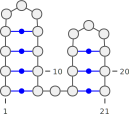

Target 1: ((((((......)))...)))
['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                     ', '-structureDBN', '((((((......)))...)))', '-o', '/tmp/tmp_8o4reys.svg']


Output file: /tmp/tmp_8o4reys.svg



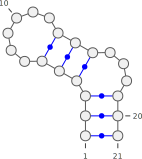

Target 2: ......(((...)))......
['java', '-cp', 'VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', '                     ', '-structureDBN', '......(((...)))......', '-o', '/tmp/tmpszjzbd3i.svg']


Output file: /tmp/tmpszjzbd3i.svg



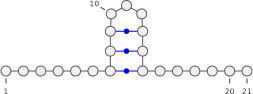

In [2]:
## our target RNA secondary structure
targets = [
#    012345678901234567890
    "((((...)))).(((...)))",
    "((((((......)))...)))",
    "......(((...)))......"
]

def plotRNA(structure, sequence=None, filename=None, show=True):
    n=len(structure)
    if sequence is None:
        sequence = ' '*n
    
    if filename is not None and not filename.endswith(".svg"):
       filename+=".svg" 

    f = filename
    if filename is None:
        f = tempfile.NamedTemporaryFile(suffix=".svg")
        filename = f.name
    
    v = varnaapi.Structure(structure=structure,sequence=sequence)
    v.set_algorithm('radiate')
    v.savefig(filename)
    subprocess.run(["inkscape", "-D", filename, "--export-overwrite"], capture_output=True)
    if show:
        display(SVG(filename))
    
    return f
    
for i, target in enumerate(targets):
    print(f"Target {i}: {target}")
    if has_module("varnaapi"):
        plotRNA(target)

## Construct the Infrared model

In [3]:
def construct_design_model(targets):
    seqlen = len(targets[0])
    ######
    # construct the constraint model
    model = ir.Model()

    # one variable X_i per position i;
    # the value of X_i encodes the nucleotide at position i   
    model.add_variables( seqlen, 4 )


    for i,target in enumerate(targets):
        bps = rna.parse(target)

        model.add_constraints( rna.BPComp( i, j ) for ( i, j ) in bps )

        model.add_functions( [ rna.BPEnergy( i, j, False ) 
                               for ( i, j ) in bps ], group = f'bpenergy{i}' )

        model.add_feature( f'E{i}', # feature name
                           f'bpenergy{i}', # controlled group(s)
                           #
                           # function to evaluate the feature for a sample;
                           # NOTE how we have to bind i
                           lambda sample, i=i: RNA.energy_of_struct( rna.values_to_seq( sample.values() ),
                                                  targets[i] )
                         )

    model.add_functions( [ rna.GCCont( i = i ) for i in range(seqlen) ], group = 'gc' )


    model.write_graph('dependency_graph.dot', True)
    ir.dotfile_to_pdf('dependency_graph.dot')

    # the model generates automatic features 'bpenergyI', 'gc' from the function groups;
    # as well as total feature combining all function groups;
    # however, we want to diretly control Turner energy (instead of base pair energy).
    # For this purpose, add additional features 'EI'

    return model

## Some helper functions for showing the outcome of sampling

In [4]:
def draw_logo(sequences, filename=None):
    """Draw sequence logo for a set of sequences"""
    import logomaker as lm
    import matplotlib.pyplot as plt
        
    matrix = lm.alignment_to_matrix(sequences = sequences)
    logo = lm.Logo(matrix)
    logo.style_xticks(rotation=90, fmt='%d', anchor=0, spacing=5)
    logo.ax.xaxis.set_ticks_position('none')
    if filename is not None: plt.savefig(filename)
    plt.show()

def print_sample(design):
    seq = rna.values_to_seq( design.values() )
    print(seq)

def show_designs(designs, maxdesigns=10, plotlogo=False, plotdist=False, returnresults=False, filename=None):
    """
    Produce report of sequence designs
    Args:
        designs    list of assignments of the design model
        maxdesigns show first maxdesigns designs
        plotlogo   if true, plot logo
    """
    
    sequences = []
    
    statistics = defaultdict(list)
    
    for i,design in enumerate(designs):
        seq = rna.values_to_seq( design.values() )
        sequences.append(seq)
        
        
        stats = { f'E{j}': model.eval_feature(design, f'E{j}') for j in range(len(targets))}
        stats['GC'] = round(model.eval_feature(design, 'gc')*100/len(seq))

        for k in stats:
            statistics[k].append(stats[k])
        
        if i<maxdesigns:
            print(seq,end="")
            for k in stats:
                print(f" {k}={stats[k]:.2f}",end="")
            print()
        
    if maxdesigns<len(designs):
        print(f"... skip {len(designs)-maxdesigns} designs")
    
    if plotlogo:
        print()
        print(f"Sequence logo from {len(designs)} sequences:")
        draw_logo(sequences, 
                  filename=filename+"_logo.svg" if filename is not None else None)

    
    if plotdist:
        fig,axs = plt.subplots(1, 2, figsize=(10, 2.5), width_ratios=[1,2])

        # plot only gc in first histogram
        sns.histplot(statistics['GC'],ax=axs[0], stat='probability', discrete=True, color=[0.8,0.2,0,0.6])
        
        del statistics['GC'] # take out gc for second histogram
        
        # make Ei one based for the plot
        statistics = { f'E{i+1}': statistics[f'E{i}'] for i in range(len(statistics)) }

        sns.histplot(statistics, ax=axs[1], stat='probability',
                     palette={'E1':[0.0,0.8,0.2,0.5],
                              'E2':[0.0,0.3,0.9,0.5],
                              'E3':[0.8,0.4,0.1,0.5]}
                    )
        axs[1].set_ylabel("")
        
        if filename is not None:
            fig.savefig(filename+"_hist.svg")
        fig.show()
        
    if returnresults:
        return sequences, statistics

## Sampling from the design model

Tree width: 1

Time: 0.02s
GCGCGCCGCGCGGCGUAUCGU E0=-4.90 E1=-2.60 E2=-1.40 GC=81.00
GCGCGCUGCGCUGCGCAGCGC E0=-5.40 E1=-5.10 E2=0.40 GC=86.00
CGCGCGGCGUGACGCAUAGCG E0=-2.90 E1=-5.50 E2=-1.80 GC=76.00
GCGCGUCGCGUAGCGUUUCGC E0=-3.70 E1=-2.30 E2=-1.10 GC=71.00
CGCGCGGCGUGUCGCUCUGCG E0=-2.00 E1=-4.50 E2=-1.40 GC=81.00
CGCGCGGCGCGACGCACUGUG E0=-2.90 E1=-3.60 E2=-1.80 GC=81.00
CGCGCGGCGCGUCGCUAAGCG E0=-3.90 E1=-4.50 E2=-1.40 GC=81.00
CGCGCGGUGUGGCGCAUUGCG E0=-1.30 E1=-5.20 E2=0.10 GC=76.00
GCGCGCCGCGUGGCGCAGCGC E0=-3.50 E1=-4.00 E2=-1.10 GC=90.00
GCGCGCCGCGCUGCGUUUCGC E0=-5.40 E1=-3.80 E2=-1.40 GC=81.00
... skip 990 designs

Sequence logo from 1000 sequences:


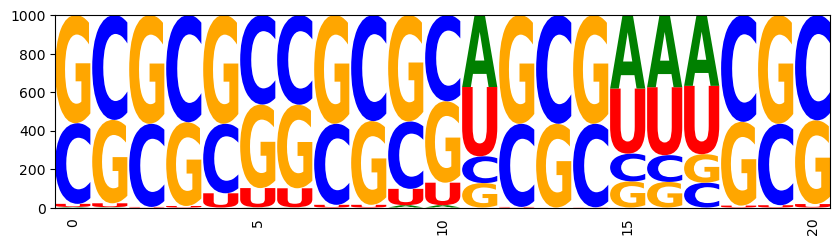

/tmp/ipykernel_812466/627987535.py:77: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


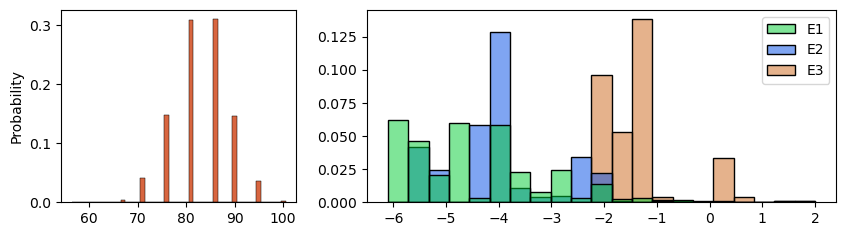

In [5]:
model = construct_design_model(targets)

model.set_feature_weight( -2, 'bpenergy0' )
model.set_feature_weight( -2, 'bpenergy1' )
model.set_feature_weight( -2, 'bpenergy2' )
model.set_feature_weight( -1, 'gc' )

## Sampling at specific weights

sampler = ir.BoltzmannSampler( model )

print( "Tree width:", sampler.treewidth() )
print()

#opionally, write plot of tree decomposition to file
#tdfile = "treedecomp.pdf"
#sampler.plot_td(tdfile)

samples = report_time(lambda:[sampler.sample() for _ in range(1000)])

show_designs(samples,
    plotlogo=has_module("logomaker"),
    plotdist=has_module("matplotlib"))

## Targeting features by Multi-dimensional Boltzmann sampling

In [6]:
print("###########################################")    
## MDBS

model.set_feature_weight( 0, 'E0' )
model.set_feature_weight( 0, 'E1' )
#model.set_feature_weight( 0, 'E2' )
model.set_feature_weight( 0, 'gc' )

######
# create sampler
sampler = ir.Sampler( model )

######
# set targets

# control number of gc's; we target 70% +/- 15% GC-content
seqlen = len(targets[0])
sampler.set_target( 0.85 * seqlen, 0.02 * seqlen, 'gc' )

# control Turner energy, target -2 +/- 1 kcal/mol
sampler.set_target( -2, 0.2, 'E0' )

# control Turner energy, target -2 +/- 1 kcal/mol
sampler.set_target( -3, 0.2, 'E1' )

# control Turner energy, target -2 +/- 1 kcal/mol
#sampler.set_target( -1.5, 0.2, 'E2' )

######
# and print samples
for i in range(10):
    sample = sampler.targeted_sample()
    print_sample(sample)

###########################################
CGUGCGGCGCGCCGCUUCGCG
CGUGCGGCGCGUCGCGCUGCG
CGUGCGGCGCGUCGCAGCGCG
CGUGCGGCGCGCCGCAGUGCG
CGUGCGGCGCGCCGCCAUGCG


CGUGCGGCGCGUCGCUGGGCG
CGUGCGGCGCGCCGCUACGCG
CGUGCGGCGCGCCGCAAGGCG
CGUGCGGCGCGCCGCACAGCG
CGUGCGGCGCGUCGCAGGGCG


# APPENDIX

In [7]:
# RNAfold/3str/f3.100.0.inp

benchmark_targets = [
'((((.((....)).)))).((.(((.((((.....(((..((((((.((..(((.(.....).)))..)).)).))))..)))..)))).))).))....',
'..(((((.....(((.(((((((.....))))..))).))).....)))))..((((((((((...))).)....))))))...((((((....))))))',
'......(((((.....(((...(((.((.((.(((....((......))...))).)).)))))..))).............))))).((((...)))).'
]


Time: 0.40s
CUCCCGCCCUUGCAGGGGGGGGGCCUCCCCCUCCCCCGCUGGCUAAGCGGGAGGGCGGCGGGGCUUCCCGCUUUAGCCGCCGGAGGGGGGGGCACCCCCC E0=-35.20 E1=-53.90 E2=-29.80 GC=81.00
CGGGGGCGUACGCUCCCGCCGCGGCUGCCGCGGUGCGGGGGCCUAAGCCUCACGCCGCCGCGCCGUGCGGCUUAAGGCGGCCGUGCGGCGGCCACGCCGC E0=-35.10 E1=-45.40 E2=-22.70 GC=83.00
CUUGCGCCUACGCGCAGGGGGGGCCUCCCCCCCCCCCGGCGGAAGAGCGCAAGGGUGGAGGGGCUUCCCGCUCUUUCCACCGGUGGGGGGGGCACCCCCC E0=-31.40 E1=-49.20 E2=-30.40 GC=78.00
GCGCCGCCGUGGCGGCGCGGGGGCGUCGCCCCUUCGCGCCGGAAAAGCGGUUGGAGGGACGCGCCACGCGGUUAUUCCCUCGCACGGCGGCGUUCCGCCG E0=-37.00 E1=-43.90 E2=-24.30 GC=78.00
UGGCGCGGUACCGCGCCGCCCCCGCAGCGGGGCGGCGCUGCCAAAACGCGUACCGCCCAGCGCGGUGCGCCUUUUUGGGCGCGUGCCGCCGCGAGGCGGC E0=-32.00 E1=-45.70 E2=-24.60 GC=80.00
UCGCCGCCGUCGCAGUGGGGGGGCCACCCCCCGCCCCGCUGGGGUGGCGGCAGGCCGGGGGGGCCUCCCGUCAAUCCCGGCGGACGGGGGGGCUCCCCCG E0=-33.80 E1=-49.60 E2=-30.00 GC=85.00
CCCCCCGCCUCCGGGGGGGGCGCCCACCGCGCCGCCCCCCCGCUUACGGGGUGCGCCGCGGGGGCACCCCCUAUAGCGGCGGGAGGCGGCGGGAGCCGCC E0=-41.00 E1=-51.40 E2=-29.80 GC=87.00
GGCGGCGG

... skip 4990 designs

Sequence logo from 5000 sequences:


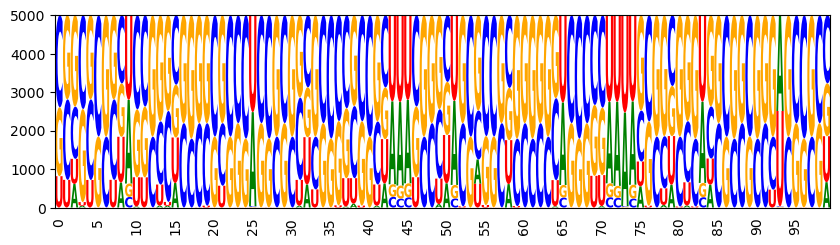

/tmp/ipykernel_812466/627987535.py:77: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Time: 0.46s
GAGGAGUAUGAAUCUUUUUUGUGAACGAUGCGUUGAGAGGGUCUUGAUUUCUUGGGGUCUCUUUGGAAGGGCAGGGGUUUUUUCGUGUUGUUUAUGACAU E0=18.40 E1=6.40 E2=7.50 GC=43.00
GACUGGUACGGGUCAGUUCUGUGAGGGAUGUGCCGGAGUGGCGGUGAUCAGUUGGAGUGUUUUCGGGAGAGCACCCGCUCCUCUGUAUCGUUCUCGGUGU E0=-12.10 E1=-3.30 E2=8.80 GC=58.00
CGAUAACGCUCGUUGUUGUCAUGGUCAUCGUGUUACGGCAACGGUAGUUAUUUAGUACGAUGUUGAGCGAUUACCUGUGUUCGAGUGGUAGUUCUGCUGC E0=2.90 E1=-4.10 E2=7.10 GC=47.00
AUGUUUGUUUGUGGGUAUAGUGUCGAUGGCGUAGUAUCUUUAGGUCUGGGCUGUUGUGGCGCGGCAUGUUGGAACCUAUGGGUGGGUUGUUGAUAUAACC E0=-0.40 E1=3.60 E2=12.60 GC=48.00
GGAUAUAGCCAUAUAUUCUUUUCGGCGGGAGAUGAGGCUGUCGAGCUGUGUAUUGAUUGCUUCGAUGGAUGGUUUCGGUCGUUGGUUUUUUUGUGAAAGC E0=-1.40 E1=-3.60 E2=5.60 GC=45.00
UGUUAUGAGCCUACGACAUUUUCGUAGUGGGACAGUGUUGUCGUAUCGUGGCUUGUUCGGUGCGGGGUGCCAUCGCGGAUGCGGUUUAUUAUGAGGUGAA E0=-1.20 E1=-0.50 E2=6.60 GC=51.00
GUGACUGCAGAUAGUCACGGUGUCGGCGGCGCCACGUCGUUGUUGUCGGUCUGUGGUGUUGCGACGCGUUGAUAAGUGUCGAUUUGUCGCCGGCGUGGCG E0=1.40 E1=-1.80 E2=-5.80 GC=61.00
GCGUCCGCUCACGGGUGUGGCGUUGGUGGCGCUACAU

... skip 4990 designs

Sequence logo from 5000 sequences:


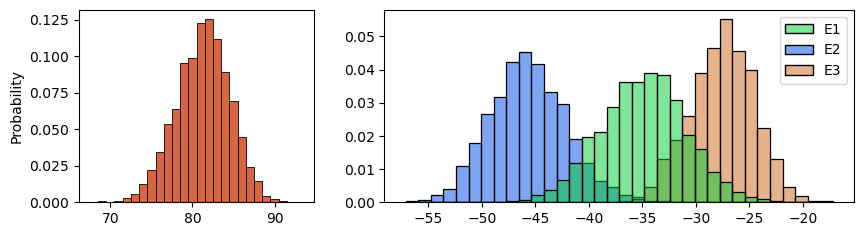

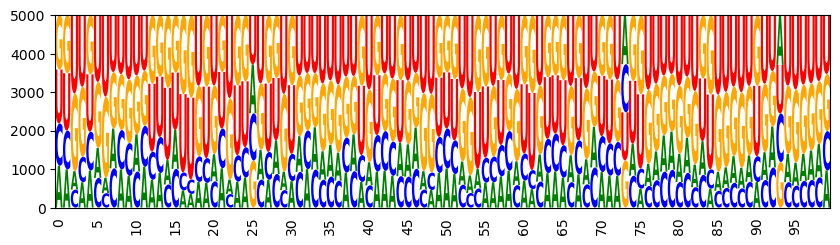

/tmp/ipykernel_812466/627987535.py:77: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


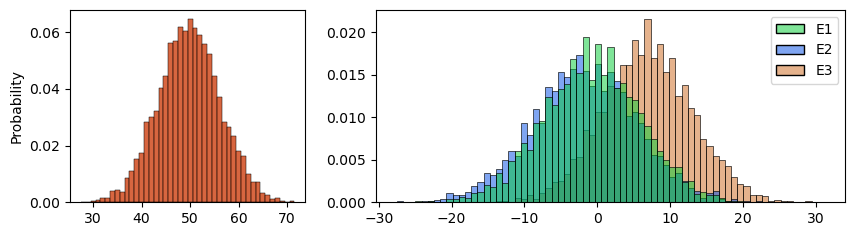

In [8]:
model = construct_design_model(benchmark_targets)

for weight in [-5,0]:
    for i in range(3):
        model.set_feature_weight( weight, f'bpenergy{i}' )
    model.set_feature_weight( weight, 'gc' )

    ## Sampling at specific weights

    sampler = ir.BoltzmannSampler( model )

    samples = report_time(lambda:
        [sampler.sample() for _ in range(5000)])
    
    show_designs(samples,
        plotlogo=has_module("logomaker"),
        plotdist=has_module("matplotlib"),
        filename=f"f3_{weight}")

In [9]:
def model_objective(model, assignment):
    return sum(f.weight*model.eval_feature(assignment,fname) for fname, f in model.features.items() if f.weight!=0)

In [10]:
model = construct_design_model(benchmark_targets)
model.set_feature_weight( -3, 'E0' )
model.set_feature_weight( -4, 'E1' )
model.set_feature_weight( -5, 'E2' )
model.set_feature_weight( -6, 'gc' )

sampler = ir.Sampler(model)
# draw samples
for i in range(10):
    sample = sampler.sample()
    print_sample(sample)
    print([(f.weight, model.eval_feature(sample,fname)) for fname, f in model.features.items() if f.weight!=0])
    print(model_objective(model,sample))

UUGUUCGCUAUUGGAUGGGACGCCCUCUGCGUAGCUUUUCCAAUAAUGGAUAGCUUCGAAGGGGUUCCCUUUUUAUUGAAGAAUAGCGGCGGGUGUCGCU
[(-3, -36.316440000000014), (-3, -6.800000190734863), (-4, -44.01118000000002), (-4, -21.0), (-5, -41.33763000000001), (-5, -20.0), (-6, 49)]
402.0821905722048
UUUACCGCUAUUGGUAGGGGCGCCCACCGCGUUGUUUUACCAAUAACGGUAAACAUCGAGGGGGUUCCCUCUUAAUUGAUGAAUAGCGGCGGGAGCCGCU
[(-3, -38.38947000000002), (-3, -13.199999809265137), (-4, -48.024850000000015), (-4, -28.700000762939453), (-5, -42.55497000000001), (-5, -22.700000762939453), (-6, 53)]
469.94266629425067
UCUUUCGCAUUCGAAAGGGGCGCCCACCGCGUUACCCUUUCAAAAAUGGAAUGUAUCGAGGGGGUACCCUUUUAUUUGAUAGGAUGCGGCGGGAGCCGCA
[(-3, -42.76479000000003), (-3, -15.100000381469727), (-4, -44.86687000000001), (-4, -25.100000381469727), (-5, -41.69928000000001), (-5, -21.700000762939453), (-6, 53)]
452.45825648498555
UCAUUCGUAAUUGGAUGGAGCGCCCACCGCGUUAUUCUUCCAAAAUUGGAUAAUAUCGAGGGGGUUUCCUUAUUUUUGAUAGAUUGCGGCGGGAGCCGCA
[(-3, -39.60681000000003), (-3, -16.899999618530273), (-4

## MDBS targeting distribution plots

In [11]:
## collect some statistics
def callback(total,accepted,fstats):
    rmsd = sampler.rmsd(fstats.means(),sampler.model.features)
    the_statistics.append({'samples':total, 'rmsd':rmsd, 'accepted':accepted})
    #print(fstats.report(),total,accepted,rmsd)
    
the_statistics = list()

In [12]:
model = construct_design_model(benchmark_targets)

model.set_feature_weight( 0, 'E0' )
model.set_feature_weight( 0, 'E1' )
model.set_feature_weight( 0, 'E2' )
model.set_feature_weight( 0, 'gc' )

######
# create sampler
sampler = ir.Sampler( model )

sampler.samples_per_round = 500
sampler.tweak_factor = 0.1
sampler.cooling = 2**(1/16)
sampler.verbose = True

sampler.callback = callback


######
# set targets

# control number of gc's
seqlen = len(benchmark_targets[0])
sampler.set_target( 0.85 * seqlen, 0.05 * seqlen, 'gc' )

# control Turner energy
sampler.set_target( -40, 0.5, 'E0' )

# control Turner energy
sampler.set_target( -40, 0.5, 'E1' )

# control Turner energy
sampler.set_target( -30, 0.5, 'E2' )

######
# and generate targetd samples
the_samples = report_time(
    lambda: [sampler.targeted_sample() for i in range(100)])

-- 500 0 0.0000 Tweak factor 0.1 Samples per round 500 RMSD 36.610
E0=-1.69 +/-7.41 E1=-2.55 +/-7.26 E2=6.17 +/-6.23 gc=50.60 +/-6.13
Weights {'E0': -3.831, 'E1': -3.745, 'E2': -3.617, 'gc': 3.44}


-- 1000 0 0.0000 Tweak factor 0.1 Samples per round 500 RMSD 5.217
E0=-39.35 +/-2.36 E1=-44.65 +/-2.07 E2=-27.28 +/-2.60 gc=93.91 +/-0.29
Weights {'E0': -3.896, 'E1': -3.28, 'E2': -3.889, 'gc': 2.548}


-- 1500 0 0.0000 Tweak factor 0.0958 Samples per round 522 RMSD 5.668
E0=-42.17 +/-3.70 E1=-45.36 +/-2.47 E2=-30.38 +/-2.26 gc=94.74 +/-0.48
Weights {'E0': -3.688, 'E1': -2.766, 'E2': -3.852, 'gc': 1.615}


-- 2022 0 0.0000 Tweak factor 0.0958 Samples per round 522 RMSD 4.939
E0=-42.70 +/-3.77 E1=-44.33 +/-2.41 E2=-29.19 +/-2.24 gc=93.42 +/-0.66
Weights {'E0': -3.43, 'E1': -2.352, 'E2': -3.93, 'gc': 0.809}


-- 2544 0 0.0000 Tweak factor 0.0917 Samples per round 545 RMSD 9.407
E0=-46.88 +/-3.34 E1=-50.62 +/-2.37 E2=-31.83 +/-2.36 gc=98.80 +/-0.97
Weights {'E0': -2.799, 'E1': -1.378, 'E2': -3.762, 'gc': -0.456}


-- 3089 0 0.0000 Tweak factor 0.0917 Samples per round 545 RMSD 7.084
E0=-45.11 +/-3.47 E1=-47.62 +/-3.44 E2=-31.53 +/-2.65 gc=95.69 +/-1.90
Weights {'E0': -2.33, 'E1': -0.679, 'E2': -3.622, 'gc': -1.436}


-- 3634 0 0.0000 Tweak factor 0.0917 Samples per round 545 RMSD 3.035
E0=-35.92 +/-4.74 E1=-35.73 +/-4.84 E2=-29.60 +/-2.76 gc=83.65 +/-3.71
Weights {'E0': -2.704, 'E1': -1.071, 'E2': -3.658, 'gc': -1.313}


-- 4179 1 0.0002 Tweak factor 0.0917 Samples per round 545 RMSD 2.503
E0=-40.99 +/-3.97 E1=-41.42 +/-4.25 E2=-30.49 +/-2.65 gc=89.67 +/-2.91
Weights {'E0': -2.613, 'E1': -0.94, 'E2': -3.613, 'gc': -1.741}


-- 4724 1 0.0002 Tweak factor 0.0878 Samples per round 569 RMSD 2.603
E0=-36.56 +/-4.66 E1=-36.43 +/-4.53 E2=-29.60 +/-2.97 gc=83.46 +/-3.75
Weights {'E0': -2.916, 'E1': -1.253, 'E2': -3.648, 'gc': -1.606}


-- 5293 1 0.0002 Tweak factor 0.0878 Samples per round 569 RMSD 1.875
E0=-40.52 +/-4.16 E1=-40.99 +/-4.27 E2=-30.20 +/-2.81 gc=88.57 +/-2.98
Weights {'E0': -2.87, 'E1': -1.167, 'E2': -3.631, 'gc': -1.92}


-- 5862 3 0.0005 Tweak factor 0.0878 Samples per round 569 RMSD 1.615
E0=-37.81 +/-4.43 E1=-37.75 +/-4.47 E2=-29.34 +/-2.92 gc=84.63 +/-3.55
Weights {'E0': -3.063, 'E1': -1.364, 'E2': -3.688, 'gc': -1.888}


-- 6431 3 0.0005 Tweak factor 0.0878 Samples per round 569 RMSD 1.066
E0=-39.64 +/-3.99 E1=-40.02 +/-4.27 E2=-29.80 +/-2.81 gc=87.09 +/-3.48
Weights {'E0': -3.094, 'E1': -1.363, 'E2': -3.706, 'gc': -2.072}


-- 7000 4 0.0006 Tweak factor 0.0878 Samples per round 569 RMSD 1.031
E0=-38.72 +/-4.26 E1=-38.54 +/-4.35 E2=-29.33 +/-2.86 gc=85.15 +/-3.57
Weights {'E0': -3.207, 'E1': -1.491, 'E2': -3.764, 'gc': -2.085}


-- 7569 4 0.0005 Tweak factor 0.0878 Samples per round 569 RMSD 0.871
E0=-39.55 +/-4.47 E1=-39.38 +/-4.31 E2=-29.56 +/-2.81 gc=86.50 +/-3.45
Weights {'E0': -3.246, 'E1': -1.545, 'E2': -3.803, 'gc': -2.216}


-- 8138 5 0.0006 Tweak factor 0.0878 Samples per round 569 RMSD 0.752
E0=-38.97 +/-4.03 E1=-39.25 +/-4.62 E2=-29.49 +/-2.77 gc=85.62 +/-3.49
Weights {'E0': -3.337, 'E1': -1.611, 'E2': -3.847, 'gc': -2.271}


-- 8707 6 0.0007 Tweak factor 0.0878 Samples per round 569 RMSD 0.639
E0=-39.35 +/-4.06 E1=-39.42 +/-4.23 E2=-29.29 +/-2.85 gc=85.61 +/-3.51
Weights {'E0': -3.394, 'E1': -1.662, 'E2': -3.909, 'gc': -2.325}


-- 9276 7 0.0008 Tweak factor 0.0878 Samples per round 569 RMSD 0.615
E0=-39.37 +/-4.28 E1=-39.65 +/-4.40 E2=-29.63 +/-2.79 gc=85.93 +/-3.59
Weights {'E0': -3.449, 'E1': -1.693, 'E2': -3.942, 'gc': -2.406}


-- 9845 8 0.0008 Tweak factor 0.0841 Samples per round 594 RMSD 0.648
E0=-38.90 +/-3.96 E1=-39.56 +/-4.27 E2=-29.61 +/-2.92 gc=85.36 +/-3.60
Weights {'E0': -3.541, 'E1': -1.73, 'E2': -3.975, 'gc': -2.436}


-- 10439 11 0.0011 Tweak factor 0.0841 Samples per round 594 RMSD 0.582
E0=-39.66 +/-3.94 E1=-39.60 +/-4.10 E2=-29.41 +/-2.78 gc=85.86 +/-3.39
Weights {'E0': -3.57, 'E1': -1.764, 'E2': -4.024, 'gc': -2.508}


-- 11033 11 0.0010 Tweak factor 0.0805 Samples per round 620 RMSD 0.615
E0=-39.64 +/-4.26 E1=-39.12 +/-4.55 E2=-29.41 +/-2.85 gc=85.51 +/-3.53
Weights {'E0': -3.599, 'E1': -1.834, 'E2': -4.072, 'gc': -2.549}


-- 11653 11 0.0009 Tweak factor 0.0805 Samples per round 620 RMSD 0.532
E0=-39.31 +/-4.05 E1=-39.71 +/-4.35 E2=-29.41 +/-3.01 gc=85.48 +/-3.57
Weights {'E0': -3.654, 'E1': -1.857, 'E2': -4.119, 'gc': -2.588}


-- 12273 13 0.0011 Tweak factor 0.0805 Samples per round 620 RMSD 0.485
E0=-39.70 +/-3.85 E1=-39.69 +/-4.17 E2=-29.68 +/-2.82 gc=85.81 +/-3.41
Weights {'E0': -3.678, 'E1': -1.883, 'E2': -4.145, 'gc': -2.653}


-- 12893 14 0.0011 Tweak factor 0.0771 Samples per round 648 RMSD 0.659
E0=-38.96 +/-3.99 E1=-39.36 +/-4.37 E2=-29.55 +/-2.74 gc=84.83 +/-3.45
Weights {'E0': -3.759, 'E1': -1.932, 'E2': -4.18, 'gc': -2.639}


-- 13541 14 0.0010 Tweak factor 0.0771 Samples per round 648 RMSD 0.612
E0=-39.69 +/-3.85 E1=-40.01 +/-4.27 E2=-29.51 +/-2.80 gc=86.08 +/-3.40
Weights {'E0': -3.782, 'E1': -1.931, 'E2': -4.217, 'gc': -2.723}


-- 14189 17 0.0012 Tweak factor 0.0771 Samples per round 648 RMSD 0.482
E0=-39.41 +/-4.10 E1=-39.55 +/-4.17 E2=-29.44 +/-2.74 gc=85.26 +/-3.62
Weights {'E0': -3.828, 'E1': -1.965, 'E2': -4.261, 'gc': -2.743}


-- 14837 18 0.0012 Tweak factor 0.0738 Samples per round 677 RMSD 0.488
E0=-39.63 +/-4.09 E1=-39.79 +/-4.19 E2=-29.36 +/-2.90 gc=85.60 +/-3.62
Weights {'E0': -3.855, 'E1': -1.981, 'E2': -4.308, 'gc': -2.787}


-- 15514 19 0.0012 Tweak factor 0.0707 Samples per round 707 RMSD 0.497
E0=-39.54 +/-4.05 E1=-39.54 +/-4.07 E2=-29.38 +/-2.83 gc=85.41 +/-3.55
Weights {'E0': -3.888, 'E1': -2.014, 'E2': -4.352, 'gc': -2.817}


-- 16221 20 0.0012 Tweak factor 0.0707 Samples per round 707 RMSD 0.368
E0=-39.48 +/-3.92 E1=-39.67 +/-4.22 E2=-29.67 +/-2.73 gc=85.23 +/-3.54
Weights {'E0': -3.925, 'E1': -2.037, 'E2': -4.375, 'gc': -2.833}


-- 16928 21 0.0012 Tweak factor 0.0677 Samples per round 738 RMSD 0.369
E0=-39.73 +/-3.85 E1=-39.78 +/-4.15 E2=-29.66 +/-2.96 gc=85.56 +/-3.60
Weights {'E0': -3.943, 'E1': -2.052, 'E2': -4.398, 'gc': -2.871}


-- 17666 24 0.0014 Tweak factor 0.0648 Samples per round 771 RMSD 0.460
E0=-39.49 +/-3.91 E1=-39.44 +/-4.42 E2=-29.51 +/-2.80 gc=85.18 +/-3.53
Weights {'E0': -3.976, 'E1': -2.088, 'E2': -4.43, 'gc': -2.883}


-- 18437 27 0.0015 Tweak factor 0.0621 Samples per round 805 RMSD 0.515
E0=-39.81 +/-3.96 E1=-40.28 +/-4.13 E2=-29.65 +/-2.82 gc=85.91 +/-3.30
Weights {'E0': -3.988, 'E1': -2.071, 'E2': -4.452, 'gc': -2.939}


-- 19242 27 0.0014 Tweak factor 0.0621 Samples per round 805 RMSD 0.501
E0=-39.52 +/-4.05 E1=-39.42 +/-4.39 E2=-29.34 +/-2.87 gc=85.04 +/-3.67
Weights {'E0': -4.018, 'E1': -2.107, 'E2': -4.493, 'gc': -2.942}


-- 20047 27 0.0013 Tweak factor 0.0621 Samples per round 805 RMSD 0.337
E0=-39.62 +/-4.06 E1=-39.74 +/-4.16 E2=-29.57 +/-2.80 gc=85.24 +/-3.42
Weights {'E0': -4.041, 'E1': -2.123, 'E2': -4.519, 'gc': -2.957}


-- 20852 27 0.0013 Tweak factor 0.0595 Samples per round 840 RMSD 0.414
E0=-39.51 +/-3.95 E1=-39.91 +/-4.05 E2=-29.52 +/-2.79 gc=85.45 +/-3.46
Weights {'E0': -4.071, 'E1': -2.128, 'E2': -4.548, 'gc': -2.984}


-- 21692 29 0.0013 Tweak factor 0.0595 Samples per round 840 RMSD 0.373
E0=-39.76 +/-3.85 E1=-39.67 +/-4.07 E2=-29.63 +/-2.80 gc=85.50 +/-3.50
Weights {'E0': -4.085, 'E1': -2.148, 'E2': -4.57, 'gc': -3.013}


-- 22532 31 0.0014 Tweak factor 0.0569 Samples per round 878 RMSD 0.417
E0=-39.37 +/-3.98 E1=-39.87 +/-4.40 E2=-29.57 +/-2.79 gc=85.31 +/-3.49
Weights {'E0': -4.121, 'E1': -2.155, 'E2': -4.595, 'gc': -3.031}


-- 23410 31 0.0013 Tweak factor 0.0569 Samples per round 878 RMSD 0.407
E0=-39.52 +/-3.88 E1=-39.62 +/-3.98 E2=-29.56 +/-2.89 gc=85.31 +/-3.44
Weights {'E0': -4.148, 'E1': -2.177, 'E2': -4.619, 'gc': -3.049}


-- 24288 34 0.0014 Tweak factor 0.0569 Samples per round 878 RMSD 0.401
E0=-39.89 +/-3.88 E1=-39.54 +/-4.21 E2=-29.52 +/-2.79 gc=85.43 +/-3.31
Weights {'E0': -4.155, 'E1': -2.203, 'E2': -4.647, 'gc': -3.073}


-- 25166 35 0.0014 Tweak factor 0.0569 Samples per round 878 RMSD 0.396
E0=-39.39 +/-3.85 E1=-39.78 +/-4.19 E2=-29.59 +/-2.87 gc=85.19 +/-3.46
Weights {'E0': -4.19, 'E1': -2.215, 'E2': -4.671, 'gc': -3.084}


-- 26044 36 0.0014 Tweak factor 0.0569 Samples per round 878 RMSD 0.330
E0=-39.95 +/-3.94 E1=-39.83 +/-4.09 E2=-29.66 +/-2.76 gc=85.54 +/-3.50
Weights {'E0': -4.192, 'E1': -2.225, 'E2': -4.69, 'gc': -3.115}


-- 26922 38 0.0014 Tweak factor 0.0545 Samples per round 917 RMSD 0.355
E0=-39.54 +/-3.96 E1=-39.73 +/-4.25 E2=-29.59 +/-2.91 gc=85.22 +/-3.55
Weights {'E0': -4.218, 'E1': -2.24, 'E2': -4.712, 'gc': -3.126}


-- 27839 39 0.0014 Tweak factor 0.0545 Samples per round 917 RMSD 0.342
E0=-39.58 +/-4.05 E1=-39.70 +/-4.23 E2=-29.62 +/-2.76 gc=85.24 +/-3.65
Weights {'E0': -4.24, 'E1': -2.256, 'E2': -4.733, 'gc': -3.14}


-- 28756 39 0.0014 Tweak factor 0.0545 Samples per round 917 RMSD 0.313
E0=-39.77 +/-3.98 E1=-39.88 +/-4.26 E2=-29.69 +/-2.67 gc=85.48 +/-3.45
Weights {'E0': -4.253, 'E1': -2.263, 'E2': -4.75, 'gc': -3.166}


-- 29673 41 0.0014 Tweak factor 0.0522 Samples per round 957 RMSD 0.356
E0=-39.55 +/-3.86 E1=-39.76 +/-4.16 E2=-29.58 +/-2.82 gc=85.27 +/-3.67
Weights {'E0': -4.276, 'E1': -2.276, 'E2': -4.771, 'gc': -3.18}


-- 30630 44 0.0014 Tweak factor 0.0522 Samples per round 957 RMSD 0.321
E0=-39.69 +/-3.87 E1=-39.78 +/-4.10 E2=-29.58 +/-2.77 gc=85.31 +/-3.47
Weights {'E0': -4.293, 'E1': -2.287, 'E2': -4.793, 'gc': -3.196}


-- 31587 44 0.0014 Tweak factor 0.0522 Samples per round 957 RMSD 0.291
E0=-39.65 +/-3.92 E1=-39.76 +/-4.14 E2=-29.68 +/-2.79 gc=85.24 +/-3.48
Weights {'E0': -4.311, 'E1': -2.3, 'E2': -4.81, 'gc': -3.208}


-- 32544 45 0.0014 Tweak factor 0.05 Samples per round 999 RMSD 0.313
E0=-39.61 +/-3.81 E1=-39.90 +/-4.17 E2=-29.66 +/-2.78 gc=85.34 +/-3.44
Weights {'E0': -4.331, 'E1': -2.305, 'E2': -4.827, 'gc': -3.225}


-- 33543 46 0.0014 Tweak factor 0.0479 Samples per round 1044 RMSD 0.400
E0=-39.74 +/-3.91 E1=-39.46 +/-4.14 E2=-29.56 +/-2.73 gc=85.29 +/-3.47
Weights {'E0': -4.343, 'E1': -2.331, 'E2': -4.848, 'gc': -3.239}


-- 34587 47 0.0014 Tweak factor 0.0479 Samples per round 1044 RMSD 0.270
E0=-39.67 +/-3.97 E1=-39.72 +/-4.29 E2=-29.82 +/-2.80 gc=85.27 +/-3.61
Weights {'E0': -4.359, 'E1': -2.344, 'E2': -4.856, 'gc': -3.252}


-- 35631 48 0.0013 Tweak factor 0.0459 Samples per round 1090 RMSD 0.311
E0=-39.71 +/-4.00 E1=-39.65 +/-4.09 E2=-29.64 +/-2.86 gc=85.22 +/-3.65
Weights {'E0': -4.372, 'E1': -2.36, 'E2': -4.873, 'gc': -3.262}


-- 36721 50 0.0014 Tweak factor 0.0439 Samples per round 1138 RMSD 0.323
E0=-39.87 +/-3.86 E1=-40.01 +/-4.25 E2=-29.84 +/-2.80 gc=85.61 +/-3.49
Weights {'E0': -4.378, 'E1': -2.359, 'E2': -4.88, 'gc': -3.289}


-- 37859 50 0.0013 Tweak factor 0.0439 Samples per round 1138 RMSD 0.262
E0=-39.78 +/-3.85 E1=-39.92 +/-3.99 E2=-29.59 +/-2.78 gc=85.22 +/-3.47
Weights {'E0': -4.388, 'E1': -2.362, 'E2': -4.898, 'gc': -3.299}


-- 38997 50 0.0013 Tweak factor 0.042 Samples per round 1189 RMSD 0.309
E0=-39.57 +/-3.97 E1=-39.75 +/-4.11 E2=-29.77 +/-2.70 gc=85.29 +/-3.42
Weights {'E0': -4.406, 'E1': -2.373, 'E2': -4.908, 'gc': -3.311}


-- 40186 54 0.0013 Tweak factor 0.042 Samples per round 1189 RMSD 0.241
E0=-39.75 +/-3.93 E1=-39.78 +/-4.19 E2=-29.69 +/-2.82 gc=85.16 +/-3.58
Weights {'E0': -4.416, 'E1': -2.382, 'E2': -4.921, 'gc': -3.318}


-- 41375 55 0.0013 Tweak factor 0.0403 Samples per round 1241 RMSD 0.328
E0=-39.64 +/-3.80 E1=-39.67 +/-3.99 E2=-29.62 +/-2.74 gc=85.23 +/-3.50
Weights {'E0': -4.431, 'E1': -2.395, 'E2': -4.936, 'gc': -3.327}


-- 42616 58 0.0014 Tweak factor 0.0403 Samples per round 1241 RMSD 0.326
E0=-39.90 +/-3.80 E1=-39.98 +/-4.24 E2=-29.63 +/-2.76 gc=85.53 +/-3.49
Weights {'E0': -4.435, 'E1': -2.396, 'E2': -4.951, 'gc': -3.348}


-- 43857 59 0.0013 Tweak factor 0.0403 Samples per round 1241 RMSD 0.299
E0=-39.68 +/-3.98 E1=-39.68 +/-4.22 E2=-29.64 +/-2.75 gc=85.13 +/-3.47
Weights {'E0': -4.448, 'E1': -2.409, 'E2': -4.965, 'gc': -3.354}


-- 45098 62 0.0014 Tweak factor 0.0403 Samples per round 1241 RMSD 0.248
E0=-39.68 +/-3.88 E1=-39.74 +/-4.10 E2=-29.78 +/-2.71 gc=85.16 +/-3.56
Weights {'E0': -4.461, 'E1': -2.42, 'E2': -4.974, 'gc': -3.36}


-- 46339 64 0.0014 Tweak factor 0.0386 Samples per round 1296 RMSD 0.264
E0=-39.80 +/-3.74 E1=-39.65 +/-4.16 E2=-29.69 +/-2.73 gc=85.14 +/-3.42
Weights {'E0': -4.468, 'E1': -2.433, 'E2': -4.986, 'gc': -3.365}


-- 47635 69 0.0014 Tweak factor 0.0386 Samples per round 1296 RMSD 0.263
E0=-39.84 +/-3.69 E1=-39.81 +/-4.04 E2=-29.71 +/-2.82 gc=85.36 +/-3.42
Weights {'E0': -4.475, 'E1': -2.441, 'E2': -4.997, 'gc': -3.379}


-- 48931 70 0.0014 Tweak factor 0.0369 Samples per round 1354 RMSD 0.312
E0=-39.47 +/-3.95 E1=-39.82 +/-4.16 E2=-29.74 +/-2.85 gc=85.09 +/-3.58
Weights {'E0': -4.494, 'E1': -2.447, 'E2': -5.007, 'gc': -3.383}


-- 50285 72 0.0014 Tweak factor 0.0369 Samples per round 1354 RMSD 0.231
E0=-39.94 +/-3.86 E1=-39.89 +/-4.16 E2=-29.71 +/-2.85 gc=85.34 +/-3.49
Weights {'E0': -4.496, 'E1': -2.452, 'E2': -5.017, 'gc': -3.395}


-- 51639 74 0.0014 Tweak factor 0.0354 Samples per round 1414 RMSD 0.283
E0=-39.61 +/-3.97 E1=-39.80 +/-4.07 E2=-29.66 +/-2.78 gc=85.10 +/-3.54
Weights {'E0': -4.51, 'E1': -2.459, 'E2': -5.03, 'gc': -3.399}


-- 53053 77 0.0015 Tweak factor 0.0354 Samples per round 1414 RMSD 0.253
E0=-39.73 +/-3.96 E1=-39.79 +/-4.18 E2=-29.84 +/-2.70 gc=85.34 +/-3.29
Weights {'E0': -4.519, 'E1': -2.466, 'E2': -5.035, 'gc': -3.411}


-- 54467 82 0.0015 Tweak factor 0.0354 Samples per round 1414 RMSD 0.242
E0=-39.68 +/-3.97 E1=-39.76 +/-4.07 E2=-29.79 +/-2.72 gc=85.18 +/-3.51
Weights {'E0': -4.531, 'E1': -2.474, 'E2': -5.043, 'gc': -3.417}


-- 55881 84 0.0015 Tweak factor 0.0339 Samples per round 1476 RMSD 0.291
E0=-39.64 +/-3.90 E1=-39.83 +/-4.20 E2=-29.64 +/-2.75 gc=85.23 +/-3.50
Weights {'E0': -4.543, 'E1': -2.48, 'E2': -5.055, 'gc': -3.425}


-- 57357 85 0.0015 Tweak factor 0.0339 Samples per round 1476 RMSD 0.208
E0=-39.78 +/-3.93 E1=-39.88 +/-4.11 E2=-29.78 +/-2.79 gc=85.25 +/-3.60
Weights {'E0': -4.55, 'E1': -2.484, 'E2': -5.062, 'gc': -3.433}


-- 58833 86 0.0015 Tweak factor 0.0324 Samples per round 1542 RMSD 0.331
E0=-39.89 +/-3.95 E1=-39.69 +/-4.10 E2=-29.61 +/-2.66 gc=85.42 +/-3.55
Weights {'E0': -4.554, 'E1': -2.494, 'E2': -5.075, 'gc': -3.447}


-- 60375 89 0.0015 Tweak factor 0.0324 Samples per round 1542 RMSD 0.200
E0=-39.88 +/-3.87 E1=-39.98 +/-4.14 E2=-29.84 +/-2.74 gc=85.34 +/-3.43
Weights {'E0': -4.558, 'E1': -2.495, 'E2': -5.08, 'gc': -3.458}


-- 61917 93 0.0015 Tweak factor 0.0324 Samples per round 1542 RMSD 0.194
E0=-39.89 +/-3.92 E1=-39.92 +/-4.31 E2=-29.77 +/-2.76 gc=85.28 +/-3.49
Weights {'E0': -4.562, 'E1': -2.498, 'E2': -5.088, 'gc': -3.467}


-- 63459 96 0.0015 Tweak factor 0.031 Samples per round 1610 RMSD 0.296
E0=-39.66 +/-3.87 E1=-39.65 +/-4.22 E2=-29.67 +/-2.71 gc=85.06 +/-3.47
Weights {'E0': -4.572, 'E1': -2.508, 'E2': -5.098, 'gc': -3.469}


Time: 30.93s


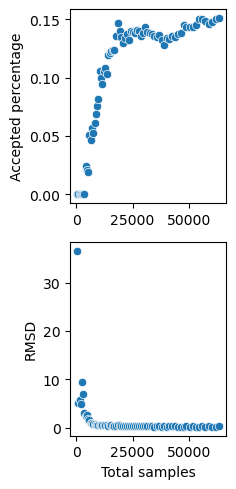

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(2.5,5))

sns.scatterplot(x=[row['samples'] for row in the_statistics], y=[100*row['accepted']/row['samples'] for row in the_statistics],ax=ax1)
ax1.set_ylabel("Accepted percentage")
sns.scatterplot(x=[row['samples'] for row in the_statistics], y=[row['rmsd'] for row in the_statistics],ax=ax2)
ax2.set_xlabel("Total samples")
ax2.set_ylabel("RMSD")
fig.tight_layout()
plt.savefig('mdbs_design_run.pdf')
plt.show()

#print(the_statistics[-1])

In [14]:
import math
def distribution_heatmaps(model,n,feature_list,fig,*,limits,labels,targets=None,ax=None,cmap="Blues"):
    sampler = ir.Sampler(model)
    samples = [sampler.sample() for _ in range(n)]
    
    def eval_features(sample):
        return {f:model.eval_feature(sample,f) for f in feature_list}
    
    features = [eval_features(sample) for sample in samples]

    k = len(feature_list)
    
    the_plots = [(i,j) for i in range(1,k) for j in range(0,i)]
    nplots = len(the_plots)
    dimx = int(math.sqrt(nplots))
    dimy = nplots // dimx
    
    the_cells = [(i,j) for i in range(0,dimx) for j in range(0,dimy)]
    
    if ax is None:
        ax = fig.subplots(dimx,dimy+1,
                          squeeze=False,
                          width_ratios=[1]*dimy+[1]
                         )

    for x in range(dimx):
        for y in range(dimy+1):
            if (x,y) not in the_cells[:nplots]:
                ax[x][y].axis("off")

    for idx,(i,j) in enumerate(the_plots):

        fi = feature_list[i]
        fj = feature_list[j]
        
        cax = ax[the_cells[idx][0]][the_cells[idx][1]]
        
        sns.kdeplot(x=[f[fj] for f in features],y=[f[fi] for f in features], ax = cax,
                cmap=cmap, levels=8, thresh=0.2, cbar = False, fill=True)
        if targets:
            cax.axhline(y = targets[fi], color = 'red', linestyle = 'dashed')
            cax.axvline(x = targets[fj], color = 'red', linestyle = 'dashed')

        cax.set_ylabel(labels[i])
        cax.set_xlabel(labels[j])

        cax.set_ylim(limits[i])
        cax.set_xlim(limits[j])

    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap),ax=ax[0][dimy],
        pad=0.2,
        location="left",
        boundaries=[0.2+i/10 for i in range(9)],
        values=[i/8 for i in range(1,9)])
    
    return ax

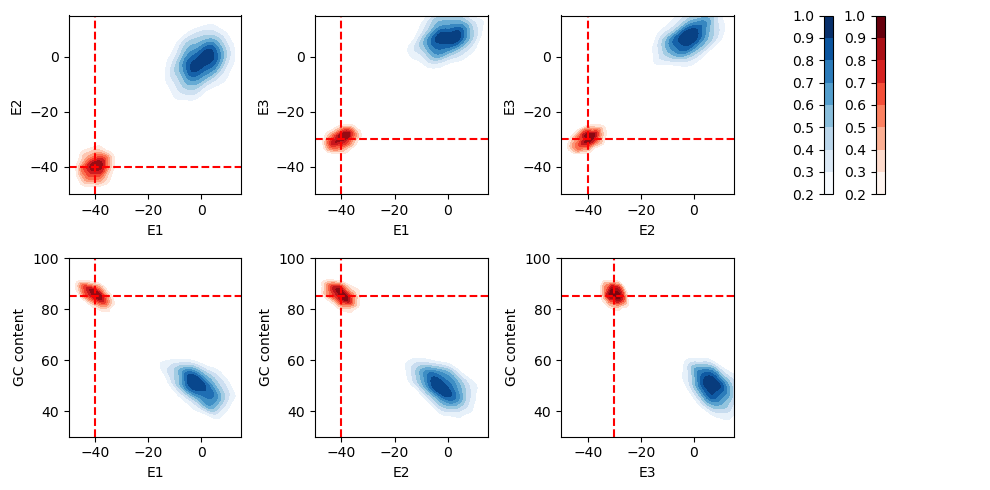

In [15]:
sel_features = ["E0","E1","E2","gc"]
labels = ["E1","E2","E3","GC content"]
limits = [(-50,15),(-50,15),(-50,15),(30, seqlen)]


n = 1000

k=len(sel_features)

targets = {k:f.target for k,f in sampler.model.features.items() if k in sel_features}


fig = plt.figure(figsize=(10,5))
ax = distribution_heatmaps(model,n,sel_features,fig,
                           limits=limits,labels=labels,cmap="Blues")
distribution_heatmaps(sampler.model,n,sel_features,fig,
                      limits=limits,labels=labels,
                      targets=targets,
                      ax=ax,cmap="Reds")
fig.tight_layout()
plt.savefig('mdbs_design_heatmaps.pdf')
plt.show()